<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/Practica5.3.%20CNN%20Preentrenadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 5.4. TRANSFER LEARNING CON REDES CONVOLUCIONALES PRE-ENTRENADAS

Una aproximación muy común y efectiva cuando se trabaja con Deep Learning sobre datasets pequeños es reutilizar redes preentrenadas. Una red preentrenada es simplemente una red grabada que ha sido entrenada sobre un dataset grande, algo muy común cuando se trabaja con problemas de clasificación de imágenes. 

Si este dataset original es suficientemente grande y suficientemente general, entonces la jerarquía de características espaciales que ha aprendido la red preentrenada puede servir como modelo genérico de nuestro mundo visual y, por tanto, sus características pueden ser útiles para muchos problemas de visión diferentes, incluso aunque estos nuevos problemas involucren clases completamente distintas a las de la tarea original. 

Por ejemplo, uno puede entrenar una red sobre [ImageNet](http://www.image-net.org) (donde las clases son principalmente de animales y objetos de uso diario) y reutilizarlo para algo tan distinto como identificar muebles. Esta portabilidad de características aprendidas entre diferentes problemas (que se suele denominar **Transfer Learning**, o **Transferencia de Aprendizaje**) es una ventaja clave de Deep Learning en comparación con muchas otras aproximaciones clásicas de ML, y hace que DL pueda ser apropiado para atacar problemas con datasets pequeños (en contra de lo que se cree generalmente).

En lo que sigue, vamos a hacer dos aproximaciones para reutilizar modelos pre-entrenados: **Extracción de Características** y **Ajuste Fino**.

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## 1. Extracción de Características

Comenzaremos a poner en práctica el Transfer Learning mediante la **Extracción de Características**, que consiste en usar representaciones aprendidas por otras redes para extraer características interesantes de nuevas muestras. Tras esta extracción, se usa la nueva representación dada por estas características para alimentar un nuevo clasificador, que (esta vez sí) será entrenado desde cero.

Como hemos visto en los ejemplos anteriores, las CNN usadas para clasificación de imágenes constan de dos partes bien diferenciadas: comienza por una serie de capas alternadas de convolución y pooling (lo que se llama la **base convolucional**), y acaban con un **clasificador** de capas fully connected (MLP). Nosotros aprovecharemos la base convolucional de la red preentrenada para obtener las nuevas representaciones y entrenaremos un nuevo codificador en la última parte.

Es importante entender porqué reusamos únicamente la base convolucional y no usamos también la parte del clasificador denso. La razón de ignorar esta última parte es simplemente que las representaciones aprendidas en la base convolucional son más genéricas y reutilizables, contienen información acerca de conceptos genéricos, que parecen útiles para todo tipo de problemas de visión artificial. Por otra parte, las representaciones aprendidas por el clasificador son mucho más específicas y relacionadas con el problema concreto para el que se ha entrenado y las clases de ese problema. Además estas capas densas pierden información acerca de dónde se sitúan las características aprendidas, algo que puede ser útil en algunos casos.

El nivel de generalidad (y por tanto de reusabilidad) de las representaciones extraídas por las capas convolucionales dependen de la profundidad de las capas del modelo. Las primeras capas extraen mapas de características muy genéricas y locales (bordes, colores, texturas, etc.), mientras que las capas más profundas extraen conceptos abstractos más elevados (como "orejas", "ojos", etc.). En consecuencia, si el dataset sobre el que se trabaja difiere mucho del dataset original con el que fue entrenada la red, es mejor usar solo las primeras capas, y no la base convolucional completa.

En nuestro caso, intentando clasificar gatos y perros, ya hemos visto que la propia red VGG16 nos sirve porque el clasificador de la red preentrenada incluye clases que están contenidas en el problema original. Sin embargo, si existe alguna raza de perro o gato que no se incluya en ImageNet, podríamos obtener un error. Por tanto, vamos a entrenar un nuevo clasificador basándonos con la base convolucional para que el ejemplo sea lo más generalizable posible.

Por ahora, analicemos de nuevo el modelo VGG16 que hemos cargado previamente. Podrás ver que hay tres partes: features (la base convolucional), avgpool (donde se "aplana" la parte convolucional antes de pasar al clasificador) y classifier (el clasificador).

In [5]:
from torchsummary import summary
modeloVGG16 = models.vgg16(pretrained=True)

print(modeloVGG16)
summary(modeloVGG16,(3,224,224),device='cpu') # cuántos parámetros hay

/usr/local/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Si queremos quedarnos con tan solo la parte convolucional, podemos hacer con tan solo lo siguiente:

In [6]:
# Conv base es la parte de features (convoluciones + pooling)
conv_base = modeloVGG16.features.to(device)

print(conv_base)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Los modelos convolucionales que usan como un clasificador unas capas lineales, tienen restringido el tamaño de las imágenes de entrada, ya que el número de conexiones están prefijadas por el clasificador. Si quitamos el clasificador, ahora tendremos libertad de elegir nostros el tamaño de entrada. Esto vendrá perfecto para nuestro problema ya que sabemos que las imágenes serán de 150x150. 

Aquí te dejo algunos datos interesantes:
* Existen redes completamente convolucionales (*Fully Convolutional Networks*), que implementan el clasificador también con convoluciones (mediante kernels de 1x1). Estas redes por tanto admiten imágenes de tamaño arbitrario.
* Con el bloque convolucional tenemos un límite inferior en el tamaño de entrada. Y es que la imagen debe ser como mínimo de 32x32, para que los mapas de activación en la última capa tenga al menos un tamaño de 1x1.

### 1.1. Extracción de características con caché

Veamos cómo quedan los mapas de características de la última capa convolucional con el tamaño de entrada para el dataset cats vs dogs:

In [ ]:
summary(conv_base,(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

: 

El mapa de características final tiene la forma `(512, 4, 4)`. Aquí conectaremos nuestro clasificador de capas densas.

En este punto, hay dos posibles vías para proceder: 

* Ejecutar la base convolucional sobre el dataset, grabar su salida en un array, y entonces usar estos datos como entrada de un clasificador denso independiente parecido al que vimos anteriormente. Esta solución es rápida y fácil de ejecutar, porque solo requiere ejecutar la base convolucional una vez sobre cada imagen de entrada, que es la parte que más recursos consume del proceso. Por contrario, esta opción no permite hacer uso de *data augmentation*, y solo es factible si el dataset no es muy grande y cabe en memoria RAM.
* Extender el modelo (`conv_base`) añadiendo un clasificador, y ejecutar la red completa sobre los datos de entrada. Esta opción permite hacer uso de *data augmentation*, aunque consume muchos más recursos que la primera opción (para cada ejemplo, debemos pasarlo siempre a través de la base convolucional).

Con el fin de poder compararlas, vamos a mostrar ambas técnicas.

Comenzaremos por la primera opción: ejecutar `conv_base` sobre todos los datos para después usar los resultados como datos de entrada en un modelo nuevo. Comenzaremos ejecutando un DataLoader sobre un dataset de tipo `ImageFolder`, de forma similar a como hicimos en el caso anterior, para extraer las imágenes como tensores (y sus etiquetas). Posteriormente, pasaremos cada tensor (imagen) por la base convolucional para extraer las características asociadas. Estos tensores de salida los concatenaremos en un tensor "grande", que posteriormente usaremos para entrenar una pequeña red MLP.

Primero, cargamos el dataset de cats and dogs.

In [ ]:
base_dir = './data/cat_dogs'  # carpeta con subcarpetas train/validation/test 
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

batch_size = 32
# Tamaño de imagen para nuestro ejemplo
img_size = (150, 150)

# Las transformaciones deben ser las que correspondientes a VGG16
# Equivalente a models.VGG16_weights.DEFAULT.transforms() pero
# pero cambiando el tamaño de entrada. Sin data augmentation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets y dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

print('Clases (train):', train_dataset.classes)
print('Tamaños train/val/test:', len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Clases (train): ['cats', 'dogs']
Tamaños train/val/test: 1999 1000 1000


Ahora pondemos el modelo en **modo extracción de características**; esto eso, congelar sus parámetros para que no se entrenen. Para ello es tan fácil como iterar todos sus parámetros e indicar que su propiedad `requires_grad` es False. Después, podemos volver a calcular, con código Python, cual es el tamaño de los mapas de activación al final del bloque convolucional. Esto nos servirá para determinar el tamaño de los tensores que se van a generar.

In [6]:
# Congelar el bloque convolucional
for p in conv_base.parameters():
    p.requires_grad = False

# Calcular dimensión de salida al pasar una imagen de tamaño img_size por conv_base
with torch.no_grad():
    dummy = torch.zeros(1, 3, img_size[0], img_size[1]).to(device)
    out = conv_base(dummy)
    print('Conv base shape de salida (N,C,H,W):', out.shape)
    flatten_dim = int(np.prod(out.shape[1:]))
    print('Flatten dim (características por ejemplo):', flatten_dim)

Conv base shape de salida (N,C,H,W): torch.Size([1, 512, 4, 4])
Flatten dim (características por ejemplo): 8192


Hacemos un bucle que recorra un dataset (por su DataLoader) y genere un tensor de salida con todas las características extraídas. Puede requerir un tiempo según tu CPU/GPU.

In [7]:
def extract_features(dataloader, conv_base, device):
    conv_base.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device).float()
            feats = conv_base(xb)
            feats = feats.view(feats.size(0), -1)
            features_list.append(feats.cpu())
            labels_list.append(yb)
    X = torch.cat(features_list, dim=0) # concatenar características
    y = torch.cat(labels_list, dim=0).float() # Concatenar etiquetas
    return X, y

# Extraer características de train, valid y test
train_features, train_labels = extract_features(train_loader, conv_base, device)
val_features, val_labels = extract_features(val_loader, conv_base, device)
test_features, test_labels = extract_features(test_loader, conv_base, device)

print('Shapes features:', train_features.shape, val_features.shape, test_features.shape)
print('Labels shapes:', train_labels.shape, val_labels.shape, test_labels.shape)

Shapes features: torch.Size([1999, 8192]) torch.Size([1000, 8192]) torch.Size([1000, 8192])
Labels shapes: torch.Size([1999]) torch.Size([1000]) torch.Size([1000])


Las características extraídas tienen la forma `(samples, 512, 4, 4)`. A continuación alimentaremos un clasificador denso, pero hemos de aplanar los tensores, que son en 2D, para pasar a `(samples, 4 * 4 * 512)`. Definiremos una red con una capa oculta de 256 neuronas, una de dropout para regularización, y la capa de salida para clasificación binaria.

Esta vez vamos a reutilizar el bucle de entrenamiento que hicimos en la práctica 5.2, que hemos dispuesto en el fichero `auxiliar.py`.

In [8]:
%%time 
# Cargamos los bucles de entrenamiento y evaluación, y la métrica binary_accuracy
# Tal y como se definió en la práctica 5.2. Tan solo extendemos la función para 
# indicar el dispositivo donde se ejecuta (ya no es una variable global)
from auxiliar import binary_accuracy, train_model, evaluate

# Nuevo clasificador con solo 256 neuronas
classifier = nn.Sequential(
    nn.Linear(flatten_dim, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 1)
).to(device)

# Loss & optimizer (RMSprop lr=2e-5)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(classifier.parameters(), lr=2e-5)

# DataLoader para features
train_ds = TensorDataset(train_features, train_labels)
val_ds = TensorDataset(val_features, val_labels)
train_loader_f = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader_f = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Entrenar classifier sobre features
epochs = 30

history_feat = train_model(classifier, epochs, train_loader_f, val_loader_f, criterion, optimizer, device)


Epoch [00/30], Train Loss: 0.1575, Validation Loss: 0.0775, Train Accuracy: 0.9449, Validation Accuracy: 0.9736
Epoch [01/30], Train Loss: 0.0626, Validation Loss: 0.0698, Train Accuracy: 0.9816, Validation Accuracy: 0.9707
Epoch [02/30], Train Loss: 0.0451, Validation Loss: 0.0612, Train Accuracy: 0.9906, Validation Accuracy: 0.9746
Epoch [03/30], Train Loss: 0.0329, Validation Loss: 0.0598, Train Accuracy: 0.9931, Validation Accuracy: 0.9736
Epoch [04/30], Train Loss: 0.0262, Validation Loss: 0.0605, Train Accuracy: 0.9970, Validation Accuracy: 0.9746
Epoch [05/30], Train Loss: 0.0194, Validation Loss: 0.0548, Train Accuracy: 0.9965, Validation Accuracy: 0.9746
Epoch [06/30], Train Loss: 0.0173, Validation Loss: 0.0554, Train Accuracy: 0.9980, Validation Accuracy: 0.9736
Epoch [07/30], Train Loss: 0.0117, Validation Loss: 0.0547, Train Accuracy: 0.9995, Validation Accuracy: 0.9756
Epoch [08/30], Train Loss: 0.0102, Validation Loss: 0.0552, Train Accuracy: 0.9995, Validation Accuracy:

El entrenamiento es muy rápido, ya que solo tiene dos capas densas. Veamos los resultados que se obtienen:


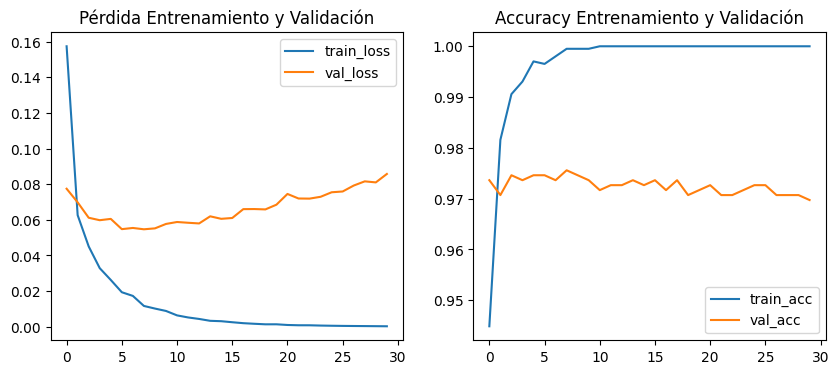

In [9]:
from auxiliar import plot_history

plot_history(history_feat)


Hemos alcanzado una precisión del ~97%, mucho más elevada que lo que conseguimos con la red convolucional entrenada completamente por nosotros en el ejemplo anterior. Sin embargo, la gráfica muestra que se sigue produciendo un sobreajuste casi desde el principio (incluso habiendo puesto una capa de dropout). Este problema se debe que el modelo hace uso de un dataset muy pequeño, que no ha sido mejorado por medio de data augmentation.

### 1.2. Extracción de características con un modelo completo

Por intentar solucionar el problema del sobreajuste, pasamos a aplicar la segunda técnica, que es mucho más lenta y cara (quizás no sea conveniente que lo intentes si no tienes una GPU a mano, en ese caso, es preferible que hagas uso de la técnica anterior), pero que permitirá evitar el problema del sobreajuste: extendemos el modelo `conv_base` con nuestras propias capas densas y ejecutamos por completo el entrenamiento de la primera capa hasta la última. 

Como los modelos se comportan igual que las capas, podemos añadir el modelo `conv_base` a un modelo secuencial como si fuera una capa más:

In [52]:
from collections import OrderedDict

# Volvemos a asegurarnos de desactivar los grandientes en conv base
for p in conv_base.parameters():
    p.requires_grad = False

# Definimos un nuevo clasificador, esta vez sin dropout
classifier2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flatten_dim, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 1)
)
# Creamos el nuevo modelo, que es la unión de los dos
model2 = nn.Sequential(
    OrderedDict([
        ("ConvBase",conv_base),
        ("Classifier",classifier2)
    ]))
# Y lo pasamos a la GPU
model2 = model2.to(device)

In [11]:
print(model2)
summary(model2,(3,150,150),verbose=0)

Sequential(
  (ConvBase): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 64, 150, 150]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 150, 150]        --
|    └─Conv2d: 2-3                       [-1, 64, 150, 150]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 150, 150]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 75, 75]          --
|    └─Conv2d: 2-6                       [-1, 128, 75, 75]         (73,856)
|    └─ReLU: 2-7                         [-1, 128, 75, 75]         --
|    └─Conv2d: 2-8                       [-1, 128, 75, 75]         (147,584)
|    └─ReLU: 2-9                         [-1, 128, 75, 75]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 37, 37]         --
|    └─Conv2d: 2-11                      [-1, 256, 37, 37]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 37,

Como puedes observar, la base convolucional de VGG16 tiene 14.714.688 parámetros, y sobre ella hemos añadido un clasificador con otros 2 millones de parámetros.

Gracias a que hemos **congelado** la base convolucional, en el proceso de entrenamiento los pesos de sus capas **no** serán modificados. Si no se hace así, las representaciones aprendidas en el entrenamiento original se modificarían. Como las capas densas que se añaden se inicializan aleatoriamente, habría grandes modificaciones sobre los pesos que se propagarían a través de la red, lo que destruiría el aprendizaje previo. Además, solo entrenamos 2 millones de parámetros de los 16 millones en total del modelo, lo cual será mucho más rápido que entrenar todo el modelo.

Ahora podemos indicar al optimizador que solo considere los parámetros que requieren gradientes. Así que podemos hacer una función que filtre dichos parámetros, que es tan sencilla que la podemos hacer con una función anónima.

In [53]:
optimizer2 = optim.RMSprop(filter(lambda p: p.requires_grad, model2.parameters()), lr=2e-5)
criterion2 = nn.BCEWithLogitsLoss()

Ahora, para combatir el sobreajuste, vamos a aplicar también data augmentation, algo que antes no podíamos hacer (o al menos no de forma dinámica durante el entrenamiento). La transformación ahora incluye una nueva opción que combina de forma aleatoria rotación, traslación y zoom. Se podrían haber dispuesto de forma separada una tras otra, pero también es interesante ver otras opciones dentro de PyTorch.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    # Combina rotación, traslación y zoom en una sola operación
    transforms.RandomAffine(
        degrees=40,             # Rango de rotación
        translate=(0.2, 0.2),   # Traslación en anchura y en altura
        scale=(0.8, 1.2),       # Zoom entre 80% y 120%
    ),   
    transforms.ColorJitter(brightness=.3, contrast=.5),
    transforms.RandomHorizontalFlip(),   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [55]:
# Datasets y dataloaders
train_dataset_DA = datasets.ImageFolder(train_dir, transform=train_transforms)
train_loader_DA = DataLoader(train_dataset_DA, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

Ahora estamos usando también la parte convolucional. Por supuesto, verás cómo el entrenamiento es mucho más pesado. Y es que el cálculo de las características es redundante, lo estamos haciendo por cada ejemplo por cada época cada vez, cuando antes lo hacíamos solo una vez previo al entrenamiento.

In [56]:
%%time 

epochs = 30

history_feat2 = train_model(model2, epochs, train_loader_DA, val_loader, criterion2, optimizer2, device)

Epoch [00/30], Train Loss: 0.3119, Validation Loss: 0.0871, Train Accuracy: 0.8739, Validation Accuracy: 0.9746
Epoch [01/30], Train Loss: 0.2194, Validation Loss: 0.0691, Train Accuracy: 0.9149, Validation Accuracy: 0.9766
Epoch [02/30], Train Loss: 0.1904, Validation Loss: 0.0645, Train Accuracy: 0.9230, Validation Accuracy: 0.9756
Epoch [03/30], Train Loss: 0.1779, Validation Loss: 0.0575, Train Accuracy: 0.9265, Validation Accuracy: 0.9775
Epoch [04/30], Train Loss: 0.1656, Validation Loss: 0.0557, Train Accuracy: 0.9300, Validation Accuracy: 0.9814
Epoch [05/30], Train Loss: 0.1526, Validation Loss: 0.0553, Train Accuracy: 0.9383, Validation Accuracy: 0.9814
Epoch [06/30], Train Loss: 0.1484, Validation Loss: 0.0559, Train Accuracy: 0.9423, Validation Accuracy: 0.9814
Epoch [07/30], Train Loss: 0.1565, Validation Loss: 0.0520, Train Accuracy: 0.9330, Validation Accuracy: 0.9824
Epoch [08/30], Train Loss: 0.1486, Validation Loss: 0.0519, Train Accuracy: 0.9368, Validation Accuracy:

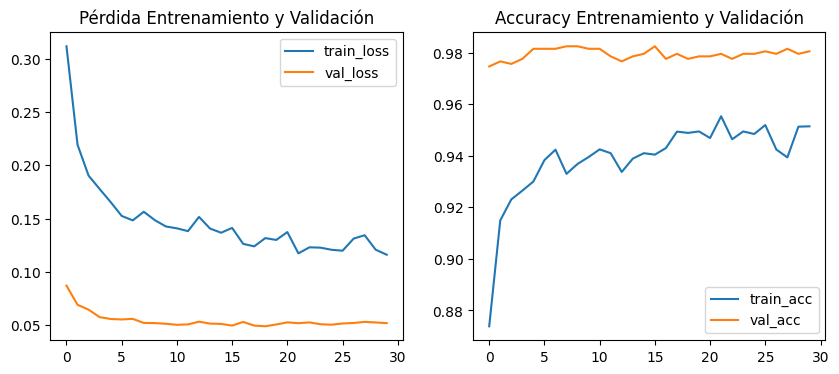

In [58]:
plot_history(history_feat2)

Vemos que alcanzamos hasta una precisión del 98%, pero sobre todo, vemos que hemos invertido la tendencia del sobreajuste. Ahora la precisión sobre el conjunto de validación es superior al de train, y esto es debido a que el conjunto de entrenamiento cambia en cada época por las trasnformaciones que aplicamos, lo cual está empujando al modelo a generalizar mejor.


## 2. Ajuste Fino (Fine Tuning)

Otra técnica muy usada para la reutilización de modelos, complementaria a la de extracción de características, consiste en lo que se conoce como **Ajuste Fino**, que consiste en descongelar algunas de las capas superiores de la base convolucional (usada para la extracción de características) y entrenarlas conjuntamente con las capas de clasificación que se han añadido sobre ellas. Se llama así porque ajusta ligeramente las representaciones más abstractas del modelo que se reusa con el fin de que se adapten al problema concreto que estamos intentando resolver.

Antes dijimos que era necesario congelar la base convolucional de VGG16 con el fin de poder entrenar el clasificador (inicializado aleatoriamente) que se ha situado encima. Por las mismas razones, solo es posible hacer un ajuste fino de las capas superiores si el clasificador que se pone encima ya ha sido entrenado de alguna forma porque, en caso contrario, el error se propagará hacia el interior de la red y perderá de nuevo las representaciones aprendidas por esas capas. Por tanto, los pasos a seguir para un ajuste fino serán:

1. Añadir la red personalizada sobre la base de la red preentrenada.
2. Congelar la base preentrenada.
3. Entrenar la parte que has añadido.
4. Descongelar algunas capas superiores de la base preentrenada.
5. Entrenar conjuntamente todas las capas (las que has descongelado y las que has añadido).

A lo largo de este ejemplo ya hemos completado las tres primeras fases de este proceso, así que comenzaremos por el 4º. Recordemos previamente cómo es la base convolucional:

In [ ]:
print(conv_base)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si


VGG16 viene definido por bloques, como se puede ver en la figura:

![](https://github.com/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/imgs/vgg16.png?raw=1)

 Lo que haremos será descongelar (y ajustar fino) las capas a partir del bloque 5 (`block3_conv1`).Podríamos intentar entrenar aún más capas, pero se debe considerar que:

* Las capas más tempranas de la base convolucional codifican características más genéricas y reutilizables, por lo que es muy probable que tengan ya el aprendizaje que nos interesa.
* Cuantos más parámetros entrenemos, mayor riesgo de sobreajuste. Tenemos cerca de 15 millones de parámaetros en nuestra base convolucional, y un dataset pequeño, así que es muy arriesgado intentar entrenar muchos parámetros.

Descongelemos las capas que necesitamos. Los bloques los podemos diferenciar porque vienen separados por las `MaxPool2d` en la salida de la celda anterior. Es decir, a partir de la capa 24.

In [59]:
# Iteramos las capas del modelo (no sus parámetros!)
for i, layer in enumerate(model2.ConvBase):
    # Descongelamos a partir de la 24
    if i >= 24:
        for p in layer.parameters():
            p.requires_grad = True

Ahora ya podemos ajustar la red. Lo haremos con el optimizador `RMSprop` pero usando una tasa de aprendizaje baja, para limitar las magnitud de las modificaciones sobre las representaciones ya aprendidas (por eso se llama _Ajuste Fino_).


In [60]:
# Redefinimos el optimizador (ahora incluye más parámetros), y bajamos el learning rate
optimizer_ft = optim.RMSprop(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-5)

In [61]:
%%time 

epochs = 100

history_feat2 = train_model(model2, epochs, train_loader_DA, val_loader, criterion2, optimizer_ft, device)

Epoch [00/100], Train Loss: 0.1344, Validation Loss: 0.0480, Train Accuracy: 0.9429, Validation Accuracy: 0.9814
Epoch [01/100], Train Loss: 0.1109, Validation Loss: 0.0507, Train Accuracy: 0.9598, Validation Accuracy: 0.9795
Epoch [02/100], Train Loss: 0.0984, Validation Loss: 0.0490, Train Accuracy: 0.9593, Validation Accuracy: 0.9795
Epoch [03/100], Train Loss: 0.0998, Validation Loss: 0.0590, Train Accuracy: 0.9598, Validation Accuracy: 0.9814
Epoch [04/100], Train Loss: 0.0957, Validation Loss: 0.0492, Train Accuracy: 0.9622, Validation Accuracy: 0.9805
Epoch [05/100], Train Loss: 0.0912, Validation Loss: 0.0520, Train Accuracy: 0.9628, Validation Accuracy: 0.9814
Epoch [06/100], Train Loss: 0.1034, Validation Loss: 0.0523, Train Accuracy: 0.9563, Validation Accuracy: 0.9824
Epoch [07/100], Train Loss: 0.0722, Validation Loss: 0.0517, Train Accuracy: 0.9722, Validation Accuracy: 0.9834
Epoch [08/100], Train Loss: 0.0726, Validation Loss: 0.0560, Train Accuracy: 0.9727, Validation 

Y mostramos los resultados obtenidos:


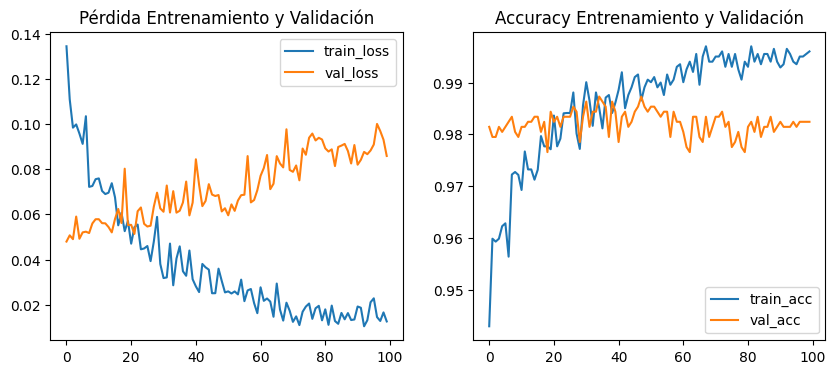

In [62]:
plot_history(history_feat2)

Vamos a suavizar las curvas para extraer más información.

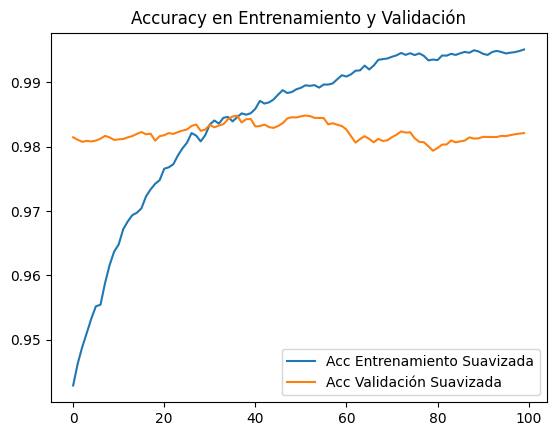

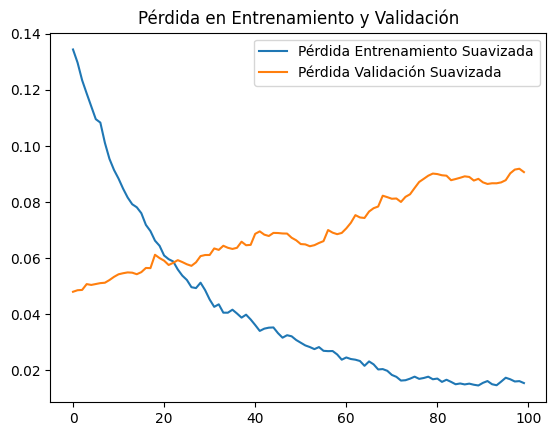

In [65]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(#epochs,
         smooth_curve(history_feat2['train_acc']), label='Acc Entrenamiento Suavizada')
plt.plot(#epochs,
         smooth_curve(history_feat2['val_acc']),  label='Acc Validación Suavizada')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(#epochs,
         smooth_curve(history_feat2['train_loss']), label='Pérdida Entrenamiento Suavizada')
plt.plot(#epochs,
         smooth_curve(history_feat2['val_loss']), label='Pérdida Validación Suavizada')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()


Observamos que se alcanza una mejora de un 6%, alcanzando el 99% en entrenamiento.

Hay algo que debemos notar, y es que la curva de accuracy no parece mejorar en validación, a pesar de que la pérdida permanece estable o incluso mejora, ¿cómo es posible? La respuesta es simple, lo que se representa es una media de los valores de pérdida puntuales, y para la precisión obtenemos un resultado que viene de binarizar el valor predicho. El modelo puede seguir mejorando en precisión pero como la binarización para el clasificador a la hora de calcular el accuracy no cambia, esas mejoras no repercuten de forma fiel en la métrica.

Por fin, podemos evaluar el modelo sobre los datos de test:

In [66]:
# Evaluación en test del modelo afinado
model2.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        logits = model2(xb).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy().tolist()
        all_preds.extend(probs)
        all_labels.extend(yb.numpy().tolist())

from sklearn.metrics import accuracy_score, roc_auc_score
preds_binary = (np.array(all_preds) >= 0.5).astype(int)
print('Test acc:', accuracy_score(all_labels, preds_binary))
print('Test AUC:', roc_auc_score(all_labels, all_preds))

Test acc: 0.973
Test AUC: 0.997942



Donde obtenemos una precisión del 97,3%, y solo con 2.000 muestras. Además, el Área bajo la Curva AUC nos indica que el clasificador es casi ideal.


## 3. Conclusiones

* Las redes convolucionales aportan los mejores modelos de ML para tareas de visión artificial. Incluso es posible entrenar una red desde cero sobre pocas muestras obteniendo resultados decentes.
* El sobreajuste es el principal problema cuando se trabaja con datasets pequeños. Entre las técnicas de regularización vistas, **data augmentation** puede ser una ayuda esencial cuando se trabaja con imágenes.
* Podemos descargar modelos pre-entrenados directamente desde PyTorch, y emplearlos para intentar clasificar imágenes. Aunque podemos encontrarnos resultados extraños si el dominio de nuestra tarea es distinta a la del dataset ImageNet.
* Es fácil reutilizar una red convolucional previamente entrenada por medio de la **extracción de características**. Es rápido y funciona bien con datasets pequeños. 
  * Primero quita el clasificador al modelo pre-entrenado.
  * Úsalo para hacer inferencia sobre el dataset. Guarda el resultado en un array.
  * Ahora entrena un nuevo modelo, que va a ser solo tu clasificador, sobre ese array.
* Como complemento a la extracción de características, el **ajuste fino** puede adaptar las representaciones aprendidas previamente por un modelo dado para ajustarlo a un problema distinto. Los recursos necesarios son más elevados, pero si se dispone de los recursos computacionales, el rendimiento obtenido es considerablemente superior.
  * Quita el clasificador al modelo pre-entrenado.
  * Crea un nuevo modelo cuya primera parte sea lo anterior, con las capas bloqueadas.
  * Añade tu nuevo clasificador.
  * Entrena el clasificador (esto es, hacer extracción de características).
  * Desbloquea algunas capas y ajusta un learning rate bajo.
  * Re-entrena más épocas (ajuste fino).
* Si el nuevo dataset que vas a usar es muy distinto al que fue usado para entrenar el modelo pre-entrenado (por ejemplo, tu dataset trata sobre [imágenes del fondo del ojo](https://www.cs.us.es/~fsancho/ficheros/IAML/UdeSevilla_slides.pdf)), puedes intentar a hacer transfer learning desde una capa anterior. Cuanto más atrás vayas, las características detectadas serán más básicas. Eso sí, siempre mantén el modelo pre-entrenado desde la primera capa hasta la que quieras usar.